# Introdução 
Kannada é um língua falada predominantemente pelo povo de Karnataka, localizada na região sudoeste da Índia. Essa língua possui aproximandente 45 milhões de praticantes.

O objetivo desse projeto é construir uma Rede Neural Convulucional (CNN) que consiga interpretar a escrita kannadense a partir de um banco de dados, onde há mais de 60.000 imagens de 0 a 9, escritos a mão, em kannadense


In [1]:
# Importando bibliotecas 
import pandas as pd
import seaborn as sns
import numpy as  np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.display.max_columns = None
%matplotlib inline

In [2]:
# Transformando datasets em dataframes
train = pd.read_csv('Kannada-MNIST/train.csv')
test = pd.read_csv('Kannada-MNIST/test.csv')
dig = pd.read_csv('Kannada-MNIST/Dig-MNIST.csv') 

___
# Conhecendo os dados 

Cada imagem possui 28 pixels em altura e 28 em comprimento, o que totaliza 784 pixels por imagem (28x28). Cada pixel tem o seu próprio valor associado, o que indica o tom claro e escuro do respectivo pixel.

Para podermos observar melhor essas imagens e como elas se comportam, realizaremos uma análise desses dados. 

In [3]:
# Checando o tamanho do nosso dataframe 
print('O dataframe de TREINO possui {} LINHAS e {} COLUNAS'.format(train.shape[0], train.shape[1]))
print('O dataframe de TESTE possui {} LINHAS e {} COLUNAS'.format(test.shape[0], test.shape[1]))

O dataframe de TREINO possui 60000 LINHAS e 785 COLUNAS
O dataframe de TESTE possui 5000 LINHAS e 785 COLUNAS


In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

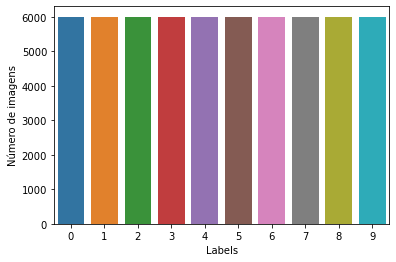

In [5]:
sns.barplot(train.label.value_counts().index, train.label.value_counts())
plt.xlabel('Labels')
plt.ylabel('Número de imagens')
plt.show()

Aqui plotamos um gráfico de barra para entendermos como está a distribuição das imagens. No nosso dataset, podemos observar que o número de imagens está uniformemente distribuido, o que nos leva a não precisar realizar algum tratamento ou manipulação em relação à quantidade para cada label.

In [6]:
train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Para cada label, temos 6.000 imagens, o que é um bom número para se trabalhar. 

Em seguida, vamos plotar uma das imagens. Como os pixels estão distribuídos em 784 colunas, precisamos reagrupá-las de forma que estajam no formato 28x28. Por isso utilizaremos o reshape.

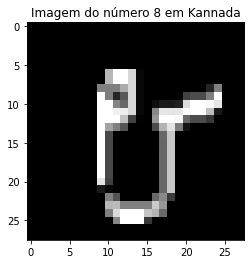

In [7]:
num = 8
number = train.iloc[num,1:].values.reshape(28,28)
plt.imshow(number, cmap=plt.get_cmap('gray'))
plt.title('Imagem do número {} em Kannada'.format(str(num)))
plt.show()

Temos uma boa noção sobre o dataset que estamos trabalhando! Agora iniciaremos o processo de montagem do nosso CNN.

___
# Pré-processamento dos dados 

Para podermos utlizar as imagens como inputs no CNN, precisamos realizar alguns processamentos.

Iniciaremos com uma separação do nosso target 

In [8]:
# Separando feature e targets 
X_train=train.drop('label',axis=1)
Y_train=train.label

Para podermos acelerar o processo de treinamento do nosso modelo, realizaremos uma normalização. Em outras palavras, já que os valores do pixel variam entre 0 e 255, dividiremos todos os valores por 255, desse modo, os inputs terão valores "leves" para serem trabalhadas no CNN. No final, os valores do pixels vão variar entre 0 e 1.

In [9]:
X_train = X_train/255
test = test/255

Também, passaremos as variáveis dos labels de numéricas para categóricas: 

In [10]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train)

Estamos prestes a montar o nosso CNN. O passo final antes de iniciar a montagem seria separar o nosso train com o auxilio do sklearn.

Decidimos utilizar a proporção de 70% e 30%

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=42) 

E mais um detalhe imporante!

Como dito antes, os pixels estão distribuídas de forma linear em 784 colunas, então precisamos agrupá-los no formato 28x28x1:

In [12]:
x_train = x_train.values.reshape(-1,28,28,1) # O -1 serve 
x_val = x_val.values.reshape(-1,28,28,1)
test = test.iloc[:, 1:].values.reshape(-1,28,28,1)

___
# Modelo 

Aqui se encontra uma breve explicação sobre CNN e algumas definições importantes: https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e

Agora iniciaremos a montagem do modelo!

In [13]:
# Importantando bibliotecas 
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, MaxPooling2D

In [14]:
# Modelo inicial
model_1 = Sequential()
model_1.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'Same',
                 activation = 'relu',
                 input_shape = (28,28,1)))

model_1.add(MaxPool2D(pool_size = (2,2)))

model_1.add(Dropout(0.25))

model_1.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'Same',
                 activation = 'relu'))

model_1.add(MaxPool2D(pool_size = (2,2)))

model_1.add(Dropout(0.25))

model_1.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 padding = 'Same',
                 activation = 'relu'))

model_1.add(Flatten())

model_1.add(Dense(256, activation = "relu"))

model_1.add(Dropout(0.5))

model_1.add(Dense(10, activation = "softmax"))

In [15]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         7

### Data Augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Otimizadores 

In [17]:
model_1.compile(optimizer = 'adam', loss='categorical_crossentropy' , metrics=['accuracy'])

### Callbacks

In [18]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

### Avaliando primeira performance 

In [19]:
epochs = 20
batch_size = 1024

Epoch 1/20
46/46 [==============================] - 18s 389ms/step - loss: 0.8165 - accuracy: 0.7248 - val_loss: 0.1166 - val_accuracy: 0.9642
Epoch 2/20
46/46 [==============================] - 18s 401ms/step - loss: 0.2182 - accuracy: 0.9320 - val_loss: 0.0540 - val_accuracy: 0.9838
Epoch 3/20
46/46 [==============================] - 19s 415ms/step - loss: 0.1357 - accuracy: 0.9584 - val_loss: 0.0491 - val_accuracy: 0.9843
Epoch 4/20
46/46 [==============================] - 19s 415ms/step - loss: 0.1058 - accuracy: 0.9678 - val_loss: 0.0365 - val_accuracy: 0.9882
Epoch 5/20
46/46 [==============================] - 19s 413ms/step - loss: 0.0945 - accuracy: 0.9714 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 6/20
46/46 [==============================] - 19s 415ms/step - loss: 0.0779 - accuracy: 0.9764 - val_loss: 0.0282 - val_accuracy: 0.9908
Epoch 7/20
46/46 [==============================] - 19s 411ms/step - loss: 0.0713 - accuracy: 0.9787 - val_loss: 0.0275 - val_accuracy: 0.9914

Text(0, 0.5, 'accuracy')

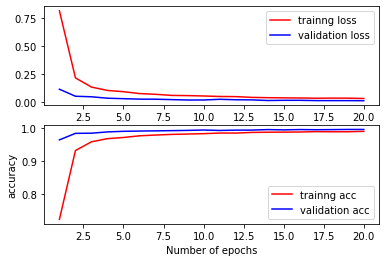

In [20]:
history = model_1.fit(datagen.flow(x_train, y_train, batch_size = batch_size,), 
                      epochs = epochs,
                      validation_data = (x_val, y_val), 
                      validation_steps = 50,
                      steps_per_epoch = x_train.shape[0] // batch_size,
                      callbacks = [learning_rate_reduction, es])

# Resultado da primeira iteração
fig,ax=plt.subplots(2,1)
fig.set
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')
ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')

In [21]:
model_1.evaluate(x_val, y_val, verbose=2);

375/375 - 2s - loss: 0.0141 - accuracy: 0.9956


### Matriz de Confusão 

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
y_predicted = model_1.predict(x_val)
y_grand_truth = y_val

y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)

cm = confusion_matrix(y_grand_truth, y_predicted)

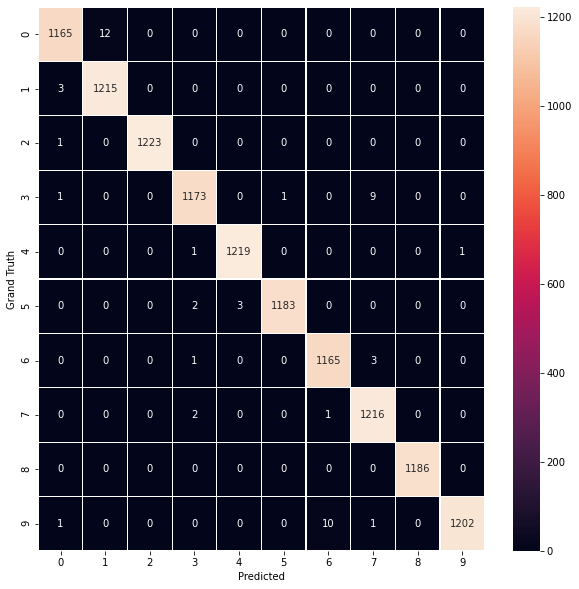

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,fmt=".0f", annot=True, linewidths=0.1)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()